<a href="https://colab.research.google.com/github/LenaGeller/Favorita-forecast/blob/main/Notebooks/Best_MAE_October_Forecast_Produce_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please note: This notebook uses relative paths (e. g. "Data/produce_2015_2017_train_ohnerank.parquet"). To run it in Google Colab, please clone the repository or replace the path with the GitHub RAW link.

## Overview

### Load the train set

In [ ]:
import pandas as pd, numpy as np, joblib
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt

df = pd.read_parquet("Data/produce_2015_2017_train_ohnerank.parquet")

df.head(10)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,near_holiday_7,promo_rollsum_7,promo_rollsum_14,is_weekend,promo_x_weekend,item_avg_sales,month_sin,month_cos,is_january,is_december
28,2015-06-29,50119485,1,1473474,123.062,False,2015,6,29,0,...,True,1.0,2.0,False,False,97.885864,1.224647e-16,-1.000000,0,0
29,2015-06-30,50197718,1,1473474,118.034,False,2015,6,30,1,...,True,1.0,2.0,False,False,97.885864,1.224647e-16,-1.000000,0,0
30,2015-07-01,50277565,1,1473474,200.614,True,2015,7,1,2,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0
31,2015-07-02,50361769,1,1473474,107.090,False,2015,7,2,3,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0
32,2015-07-03,50443262,1,1473474,136.400,False,2015,7,3,4,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0
33,2015-07-04,50525125,1,1473474,108.876,False,2015,7,4,5,...,True,1.0,2.0,True,False,97.885864,-5.000000e-01,-0.866025,0,0
34,2015-07-05,50612064,1,1473474,48.042,False,2015,7,5,6,...,True,1.0,2.0,True,False,97.885864,-5.000000e-01,-0.866025,0,0
35,2015-07-06,50697503,1,1473474,92.434,False,2015,7,6,0,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0
36,2015-07-07,0,1,1473474,0.000,False,2015,7,7,1,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0
37,2015-07-08,50856207,1,1473474,206.090,True,2015,7,8,2,...,True,1.0,2.0,False,False,97.885864,-5.000000e-01,-0.866025,0,0


In [ ]:
print(df.shape)
print(df.drop_duplicates().shape)



(74897, 59)
(74897, 59)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74897 entries, 28 to 77840
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      74897 non-null  datetime64[ns]
 1   id                        74897 non-null  int64         
 2   store_nbr                 74897 non-null  int64         
 3   item_nbr                  74897 non-null  int64         
 4   unit_sales                74897 non-null  float64       
 5   onpromotion               74897 non-null  bool          
 6   year                      74897 non-null  int32         
 7   month                     74897 non-null  int32         
 8   day                       74897 non-null  int32         
 9   day_of_week               74897 non-null  int32         
 10  city                      74897 non-null  category      
 11  type                      74897 non-null  category      
 12  cluster               

In [ ]:
check = df[(df["is_holiday"] == True) & (df["unit_sales"] != 0)]

print("❓ Rows where is_holiday=True but sales≠0:", len(check))

print(check.head())


❓ Rows where is_holiday=True but sales≠0: 0
Empty DataFrame
Columns: [date, id, store_nbr, item_nbr, unit_sales, onpromotion, year, month, day, day_of_week, city, type, cluster, some_holiday, is_bridge, is_transfer, is_work_day, is_holiday, class, lag_1, lag_7, lag_14, lag_28, roll_mean_7, roll_std_7, roll_mean_14, roll_std_14, roll_mean_28, roll_std_28, ewm_7, ewm_28, days_since_sale, days_since_promo, weekofyear, quarter, is_month_end, is_month_start, day_is_5, day_is_10, day_is_15, day_is_20, day_is_25, day_is_30, days_since_holiday, days_to_next_holiday, first_open_after_holiday, second_day_after_holiday, third_day_after_holiday, near_holiday_3, near_holiday_7, promo_rollsum_7, promo_rollsum_14, is_weekend, promo_x_weekend, item_avg_sales, month_sin, month_cos, is_january, is_december]
Index: []

[0 rows x 59 columns]


## Split

We create a forecast for Oktober 2016

In [ ]:
target = "unit_sales"
drop_cols = [target, "date", "id"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target]

cutoff_train = "2016-09-30"
valid_from   = "2016-10-01"
valid_to     = "2016-11-30"

train_idx = (df["date"] <= cutoff_train)
valid_idx = (df["date"] >= valid_from) & (df["date"] <= valid_to)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[valid_idx], y.loc[valid_idx]

print(X_train.shape, X_val.shape)

(53445, 56) (7174, 56)


In [ ]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns

print(X[cat_cols].head())

print("\nDatentypen dieser Spalten:")
print(X[cat_cols].dtypes)


     city type
28  Quito    D
29  Quito    D
30  Quito    D
31  Quito    D
32  Quito    D

Datentypen dieser Spalten:
city    category
type    category
dtype: object


## Baseline Training and Evalierung

In [ ]:
import xgboost as xgb

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True )

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_val)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


MAE  : 19.068
RMSE : 34.681
R²   : 0.942


In [ ]:
import numpy as np

bias = np.mean(y_pred - y_val)
mad = np.mean(np.abs(y_val - np.mean(y_val)))
rmad = mae / np.mean(y_val)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

print(f"Bias : {bias:.3f}")
print(f"MAD  : {mad:.3f}")
print(f"rMAD : {rmad:.3f}")
print(f"MAPE : {mape:.2f}%")


Bias : -0.564
MAD  : 99.766
rMAD : 0.173
MAPE : inf%


In [ ]:
holiday_idx = X_val['is_holiday'] == 1
mae_holiday = mean_absolute_error(y_val[holiday_idx], y_pred[holiday_idx])
print(f"MAE auf Holidays: {mae_holiday:.3f}")


MAE auf Holidays: 1.289


In [ ]:
import pandas as pd

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(58))


                     Feature  Importance
17                     lag_7    0.358530
20               roll_mean_7    0.329719
18                    lag_14    0.095434
19                    lag_28    0.087683
27                    ewm_28    0.035345
24              roll_mean_28    0.010185
14                is_holiday    0.007907
26                     ewm_7    0.007547
16                     lag_1    0.006746
28           days_since_sale    0.004455
22              roll_mean_14    0.004244
6                day_of_week    0.003558
44   third_day_after_holiday    0.003474
2                onpromotion    0.003275
29          days_since_promo    0.002918
43  second_day_after_holiday    0.002593
25               roll_std_28    0.002174
10              some_holiday    0.002171
40        days_since_holiday    0.002096
34                  day_is_5    0.002078
39                 day_is_30    0.002005
41      days_to_next_holiday    0.001975
30                weekofyear    0.001838
45            ne

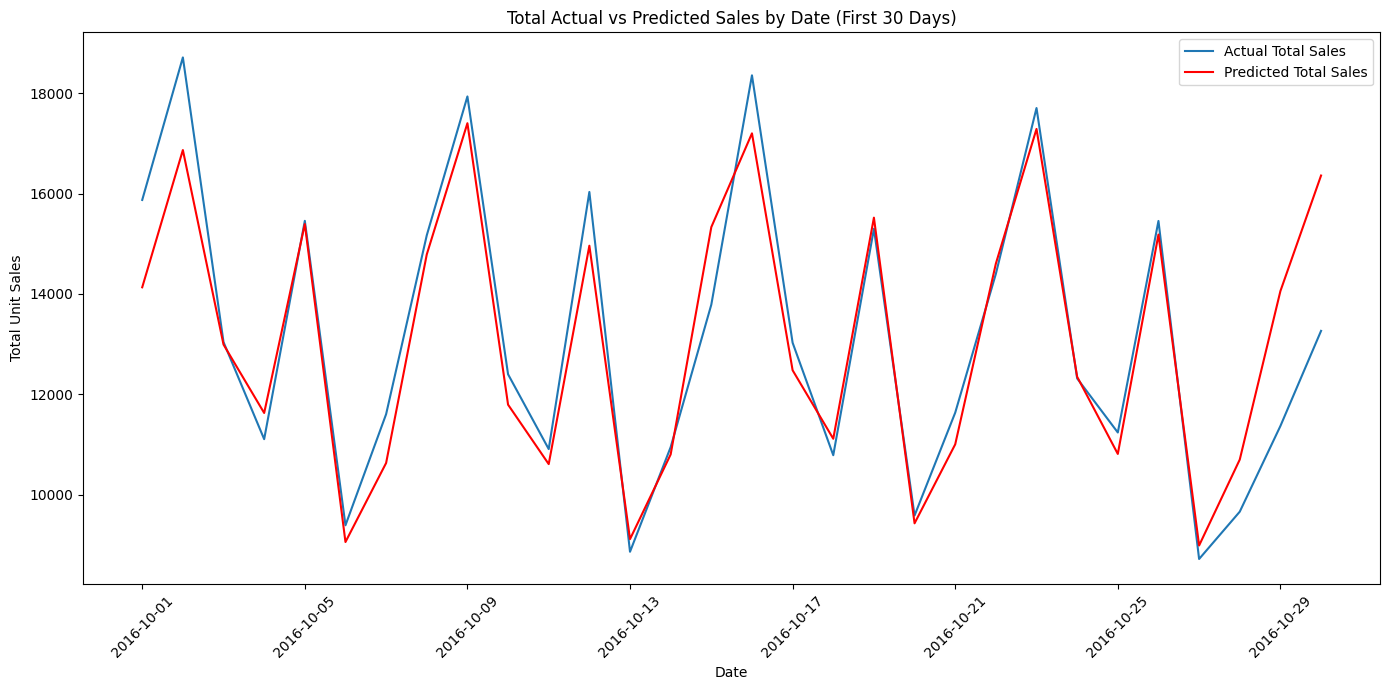

In [ ]:
test_with_date = df.loc[valid_idx].copy()
test_with_date['y_pred'] = y_pred
test_with_date['y_actual'] = y_val.values

test_with_date['date'] = pd.to_datetime(test_with_date['date'])

plot_df = test_with_date.groupby('date')[['y_actual', 'y_pred']].sum()

plt.figure(figsize=(14, 7))
plt.plot(plot_df.index[:30], plot_df['y_actual'][:30], label='Actual Total Sales')
plt.plot(plot_df.index[:30], plot_df['y_pred'][:30], label='Predicted Total Sales', color='red')
plt.title('Total Actual vs Predicted Sales by Date (First 14 Days)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 3]
}

y_log = np.log1p(y_train)

param_list = list(ParameterSampler(param_dist, n_iter=20, random_state=42))

tscv = TimeSeriesSplit(n_splits=3)

best_model = None
best_score = np.inf
best_params = None

for params in param_list:
    val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_log, y_val_log = y_log.iloc[train_idx], y_log.iloc[val_idx]

        model = XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            enable_categorical=True,
            n_jobs=-1,
            **params
        )
        model.fit(X_tr, y_tr_log)

        y_pred_log = model.predict(X_val)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_val_log)

        score = mean_absolute_error(y_true, y_pred)
        val_scores.append(score)

    avg_score = np.mean(val_scores)

    if avg_score < best_score:
        best_model = model
        best_score = avg_score
        best_params = params

print("✅ Best Score (MAE, rücktransformiert):", best_score)
print("🎯 Best Parameters:", best_params)


Best MAE (orig. Skala): 7.421499809821295
Best Params: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


## Training with best parameters

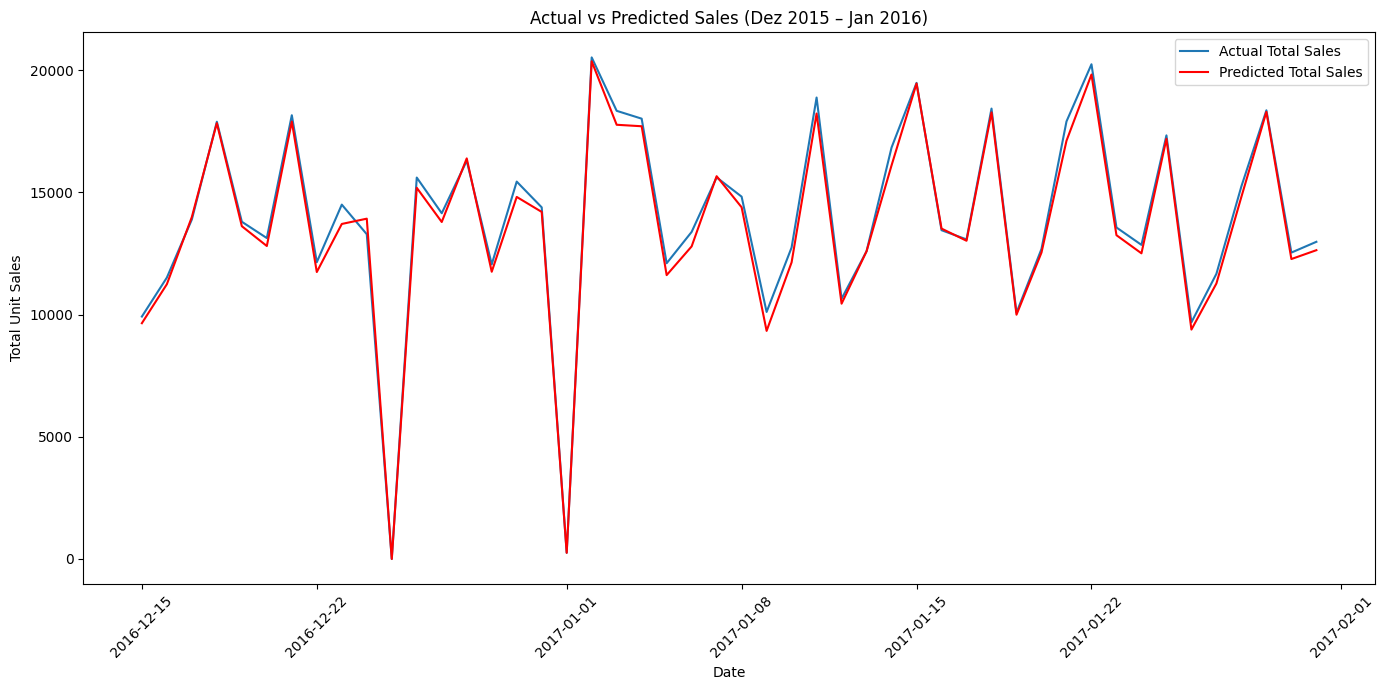

In [ ]:
import numpy as np
from xgboost import XGBRegressor

X = df.drop(columns=['unit_sales', 'date', 'id'], errors='ignore')
y = df['unit_sales'].values.astype(float)

y_log = np.log1p(y)

best_params = {
    'subsample': 0.9,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 400,
    'min_child_weight': 3,
    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.9
}


model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42,
    **best_params
)

model.fit(X, y_log)

y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)

test_with_date = df.copy()
test_with_date['y_pred'] = y_pred
test_with_date['y_actual'] = y

test_with_date['date'] = pd.to_datetime(test_with_date['date'])

mask = (test_with_date['date'] >= "2016-12-15") & (test_with_date['date'] <= "2017-01-31")
subset = test_with_date.loc[mask]

plot_df = subset.groupby('date')[['y_actual', 'y_pred']].sum()

plt.figure(figsize=(14, 7))
plt.plot(plot_df.index, plot_df['y_actual'], label='Actual Total Sales')
plt.plot(plot_df.index, plot_df['y_pred'], label='Predicted Total Sales', color='red')
plt.title('Actual vs Predicted Sales (Dez 2015 – Jan 2016)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

MAE  : 12.269
RMSE : 22.162
R²   : 0.976


# Forecast

### Calender

Here we load the prepared forecast dataset, restrict it to Store 1 and a given period, and clear all future-dependent features (lags, rolling stats, unit_sales, averages, ranks) from 1. Oktober 2016 onwards to prevent data leakage.

In [ ]:
import pandas as pd

df_forecast = pd.read_parquet(
    "Data/produce2015-2017_forecast_ohnerank.parquet",
    engine="pyarrow"
)
df_forecast["date"] = pd.to_datetime(df_forecast["date"])

df_full = df_forecast[(df_forecast["store_nbr"] == 1) &
                 (df_forecast["date"] <= "2016-10-14")].copy()

leak_cols = [c for c in df.columns if (
    "lag" in c or "roll" in c or "ewm" in c or
    "unit_sales" in c or "avg" in c or "rank" in c
)]

mask_future = df_full["date"] >= "2016-10-01"
df_full.loc[mask_future, leak_cols] = pd.NA

print(df_full.shape)



(1506, 59)


In [ ]:
df_full.tail(5)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,near_holiday_7,promo_rollsum_7,promo_rollsum_14,is_weekend,promo_x_weekend,item_avg_sales,month_sin,month_cos,is_january,is_december
1837,2016-10-10,93429763,1,1695835,NaN,False,2016,10,10,0,...,True,NaN,NaN,False,False,NaN,-0.866025,0.5,0,0
1838,2016-10-11,93526378,1,1695835,NaN,False,2016,10,11,1,...,True,NaN,NaN,False,False,NaN,-0.866025,0.5,0,0
1839,2016-10-12,93619380,1,1695835,NaN,True,2016,10,12,2,...,True,NaN,NaN,False,False,NaN,-0.866025,0.5,0,0
1840,2016-10-13,93712107,1,1695835,NaN,False,2016,10,13,3,...,True,NaN,NaN,False,False,NaN,-0.866025,0.5,0,0
1841,2016-10-14,93802056,1,1695835,NaN,False,2016,10,14,4,...,True,NaN,NaN,False,False,NaN,-0.866025,0.5,0,0


In [ ]:
df_full = df_full.reset_index(drop=True)
df_full = df_full.drop(columns=["id"])


## Rolling Forecast

In [ ]:
holidays = set(pd.to_datetime(df_full.loc[df_full["is_holiday"], "date"]).unique())


In [ ]:
from xgboost import XGBRegressor
import numpy as np

X_train = df_full[df_full["date"] <= "2016-09-30"].drop(
    columns=["unit_sales", "date", "store_nbr", "item_nbr"]
)
y_train = df_full[df_full["date"] <= "2016-09-30"]["unit_sales"]

for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")

best_params = {
    'subsample': 0.9,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 400,
    'min_child_weight': 3,
    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.9
}

model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42,
    **best_params
)

model.fit(X_train, y_train)

print("✅ Full Model fertig trainiert mit bestem Parametern.")


✅ Full Model fertig trainiert mit bestem Parametern.


In [ ]:
drop_cols = ["unit_sales", "date", "store_nbr", "item_nbr"]

In [ ]:
import pandas as pd
import numpy as np

STORE_ID = 1
ITEMS = df_full["item_nbr"].unique()
FC_FROM = "2016-10-01"
FC_TO   = "2016-10-14"

feature_cols = df_full.drop(columns=drop_cols).columns

def one_step_features(d, hist: pd.Series, promo_hist: pd.Series = None):
    f = {}
    f["year"] = d.year
    f["month"] = d.month
    f["day"] = d.day
    f["day_of_week"] = d.dayofweek
    f["weekofyear"] = d.isocalendar().week

    f["is_holiday"] = 1 if d in holidays else 0

    for L in (1, 7, 14, 28):
        f[f"lag_{L}"] = hist.iloc[-L] if len(hist) >= L else np.nan


    f["roll_mean_7"]  = hist.iloc[-7:].mean() if len(hist) >= 7 else np.nan
    f["roll_mean_28"] = hist.iloc[-28:].mean() if len(hist) >= 28 else np.nan
    #f["roll_std_28"]  = hist.iloc[-28:].std()  if len(hist) >= 28 else np.nan
    f["ewm_28"] = hist.ewm(span=28).mean().iloc[-1] if len(hist) >= 28 else np.nan
    f["item_avg_sales"] = hist.mean() if len(hist) > 0 else np.nan
    f["roll_mean_14"] = hist.iloc[-14:].mean() if len(hist) >= 14 else np.nan

    if promo_hist is not None:

       f["promo_rollsum_7"] = promo_hist.iloc[-7:].sum() if len(promo_hist) >= 7 else np.nan

    return f

def predict_item_range(model, feature_cols, history, promo_history, start_date, end_date, item_id):
    dates = pd.date_range(start_date, end_date, freq="D")
    preds = []
    hist  = history.copy()
    promo_hist = promo_history.copy()

    for d in dates:
        f = one_step_features(d, hist, promo_hist)
        X = pd.DataFrame([f]).reindex(columns=feature_cols, fill_value=np.nan).astype(float)
        yhat = model.predict(X)[0]
        yhat = max(0.0, float(yhat))
        if f["is_holiday"] == 1:
            yhat = 0.0
        preds.append((d, yhat, item_id))

        hist.loc[d] = yhat

    return pd.DataFrame(preds, columns=["date","forecast","item_nbr"])

all_item_forecasts = []

for ITEM_ID in ITEMS:
    hist = df_full[
        (df_full["store_nbr"]==STORE_ID) &
        (df_full["item_nbr"]==ITEM_ID) &
        (df_full["date"] < FC_FROM)
    ].set_index("date")["unit_sales"]

    promo_hist = df_full[
        (df_full["store_nbr"]==STORE_ID) &
        (df_full["item_nbr"]==ITEM_ID)
    ].set_index("date")["onpromotion"]

    fc_item = predict_item_range(model, feature_cols, hist, promo_hist, FC_FROM, FC_TO, ITEM_ID)
    fc_item["store_nbr"] = STORE_ID
    all_item_forecasts.append(fc_item)

fc_df = pd.concat(all_item_forecasts, ignore_index=True)

fc_daily = fc_df.groupby("date")["forecast"].sum().reset_index()


print(fc_daily.head(20))
print(fc_df.tail(20))


         date    forecast
0  2016-10-01  362.375710
1  2016-10-02  212.478615
2  2016-10-03  354.806038
3  2016-10-04  337.460938
4  2016-10-05  442.812134
5  2016-10-06  331.818176
6  2016-10-07  335.727325
7  2016-10-08  387.718994
8  2016-10-09  184.998352
9  2016-10-10  339.944534
10 2016-10-11  316.215370
11 2016-10-12  434.350731
12 2016-10-13  298.110916
13 2016-10-14  330.332443
         date    forecast  item_nbr  store_nbr
22 2016-10-09   59.135124   1503844          1
23 2016-10-10  152.042114   1503844          1
24 2016-10-11  133.124893   1503844          1
25 2016-10-12  179.413101   1503844          1
26 2016-10-13  106.035309   1503844          1
27 2016-10-14  148.449097   1503844          1
28 2016-10-01   89.746742   1695835          1
29 2016-10-02   67.871216   1695835          1
30 2016-10-03   93.385490   1695835          1
31 2016-10-04   94.004417   1695835          1
32 2016-10-05  100.893707   1695835          1
33 2016-10-06   93.910629   1695835          1

## Evaluation

In [ ]:
calendar_cols = ["date", "is_holiday", "first_open_after_holiday",
                 "second_day_after_holiday", "third_day_after_holiday", "day_of_week"]

fc_merged = fc_daily.merge(
    df_full[calendar_cols].drop_duplicates("date"),
    on="date",
    how="left"
)

print(fc_merged.head())


        date    forecast  is_holiday  first_open_after_holiday  \
0 2016-10-01  362.375710       False                     False   
1 2016-10-02  212.478615       False                     False   
2 2016-10-03  354.806038       False                     False   
3 2016-10-04  337.460938       False                     False   
4 2016-10-05  442.812134       False                     False   

   second_day_after_holiday  third_day_after_holiday  day_of_week  
0                     False                    False            5  
1                     False                    False            6  
2                     False                    False            0  
3                     False                    False            1  
4                     False                    False            2  


In [ ]:
actual = (
    df[(df["store_nbr"] == STORE_ID) &
       (df["date"].between(FC_FROM, FC_TO))]
      .groupby("date")["unit_sales"].sum()
      .reset_index()
      .rename(columns={"unit_sales": "actual"})
)

merged = fc_daily.merge(actual, on="date", how="left")

print(merged.head(20))


         date    forecast   actual
0  2016-10-01  362.375710  417.437
1  2016-10-02  212.478615  186.152
2  2016-10-03  354.806038  343.380
3  2016-10-04  337.460938  284.183
4  2016-10-05  442.812134  495.331
5  2016-10-06  331.818176  258.866
6  2016-10-07  335.727325  348.141
7  2016-10-08  387.718994  446.122
8  2016-10-09  184.998352  200.839
9  2016-10-10  339.944534  393.833
10 2016-10-11  316.215370  280.103
11 2016-10-12  434.350731  634.984
12 2016-10-13  298.110916  253.300
13 2016-10-14  330.332443  319.261


### Plot

MAE: 50.34, RMSE: 68.23


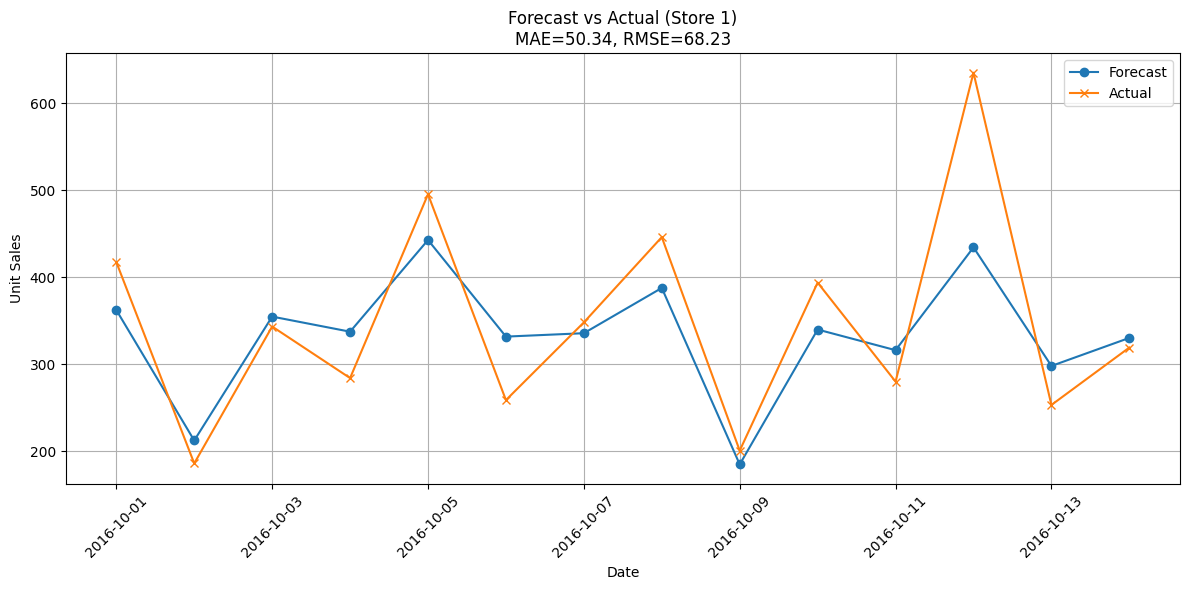

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

merged_nonan = merged.dropna(subset=["actual"])

mae = mean_absolute_error(merged_nonan["actual"], merged_nonan["forecast"])
rmse = np.sqrt(mean_squared_error(merged_nonan["actual"], merged_nonan["forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(merged["date"], merged["forecast"], label="Forecast", marker="o")
plt.plot(merged["date"], merged["actual"], label="Actual", marker="x")
plt.title(f"Forecast vs Actual (Store {STORE_ID})\nMAE={mae:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Pro Item

        date    forecast  item_nbr  store_nbr   actual
0 2016-10-01  105.079468   1473474          1  135.657
1 2016-10-02   65.868050   1473474          1   81.135
2 2016-10-03  107.473160   1473474          1  108.200
3 2016-10-04  102.593437   1473474          1   99.271
4 2016-10-05  162.012939   1473474          1  170.300
5 2016-10-06  112.860214   1473474          1   85.273
6 2016-10-07  104.328140   1473474          1  116.687
7 2016-10-08  106.713173   1473474          1  130.424
8 2016-10-09   61.383705   1473474          1   63.828
9 2016-10-10   92.091560   1473474          1  133.162


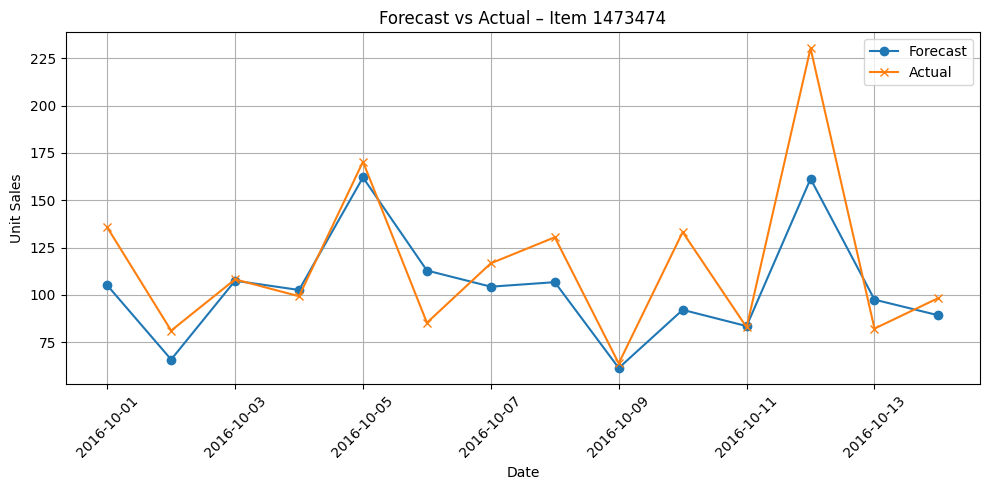

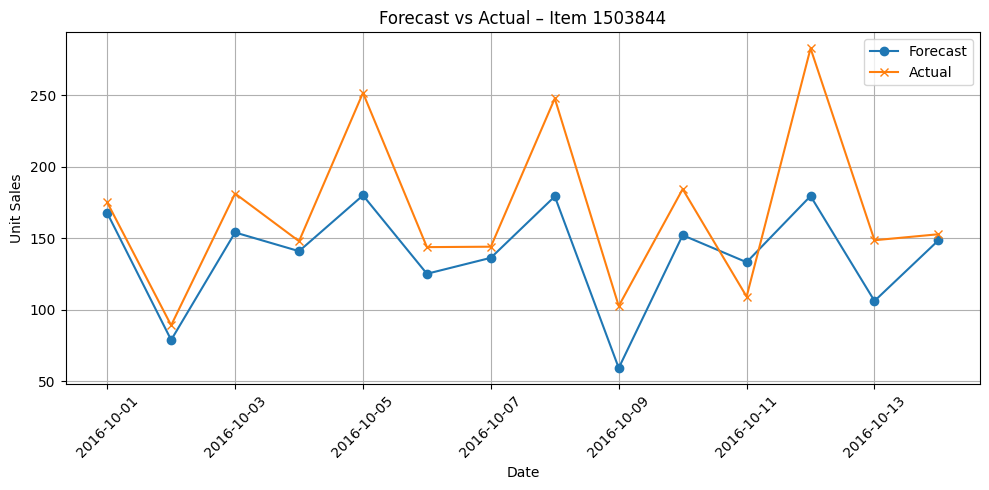

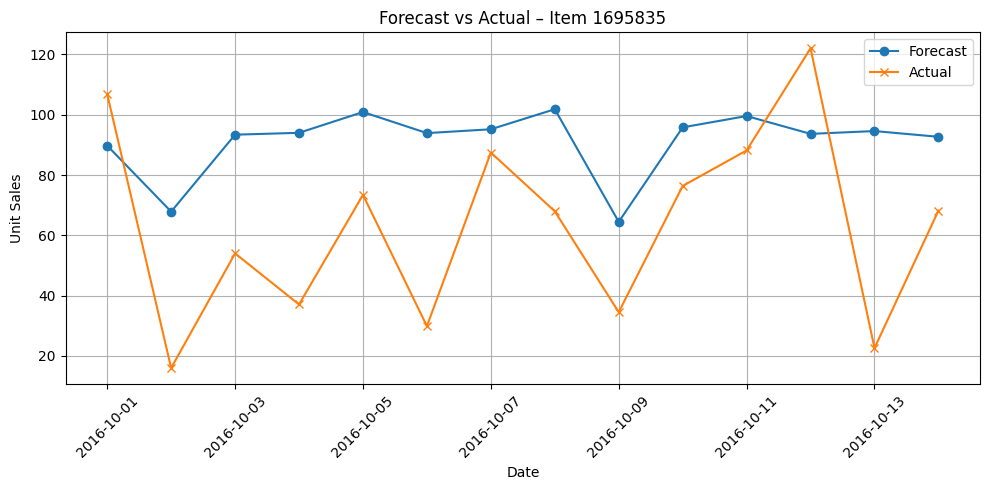

In [ ]:
actual = (
    df[(df["store_nbr"] == STORE_ID) &
       (df["date"].between(FC_FROM, FC_TO))]
    [["date", "item_nbr", "unit_sales"]]
    .rename(columns={"unit_sales": "actual"})
)

merged = fc_df.merge(actual, on=["date", "item_nbr"], how="left")

print(merged.head(10))

for item in merged["item_nbr"].unique():
    subset = merged[merged["item_nbr"] == item]

    plt.figure(figsize=(10,5))
    plt.plot(subset["date"], subset["forecast"], label="Forecast", marker="o")
    plt.plot(subset["date"], subset["actual"], label="Actual", marker="x")
    plt.title(f"Forecast vs Actual – Item {item}")
    plt.xlabel("Date")
    plt.ylabel("Unit Sales")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Promo days analysis – potential model improvement

In [ ]:
item_id = 1473474
store_nbr = 1

promo_days_item = df[
    (df["item_nbr"] == item_id) &
    (df["store_nbr"] == store_nbr) &
    (df["onpromotion"] == True)
]

avg_sales_promo_item = (
    promo_days_item.groupby("day_of_week")["unit_sales"]
    .mean()
    .reset_index()
    .sort_values("day_of_week")
)

avg_sales_promo_item["day_name"] = avg_sales_promo_item["day_of_week"].map({
    0: "Monday", 1: "Tuesday", 2: "Wednesday",
    3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"
})

print(avg_sales_promo_item)


   day_of_week  unit_sales   day_name
0            2  173.616868  Wednesday


In [ ]:
promo_days_all = df[df["onpromotion"] == True]

avg_sales_promo_all = (
    promo_days_all.groupby("day_of_week")["unit_sales"]
    .mean()
    .reset_index()
    .sort_values("day_of_week")
)

avg_sales_promo_all["day_name"] = avg_sales_promo_all["day_of_week"].map({
    0: "Monday", 1: "Tuesday", 2: "Wednesday",
    3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"
})

print(avg_sales_promo_all)



   day_of_week  unit_sales   day_name
0            0   74.329632     Monday
1            1   52.691125    Tuesday
2            2  204.164762  Wednesday
3            3   61.305889   Thursday
4            4   73.155684     Friday
5            5   92.637667   Saturday
6            6  131.104176     Sunday
